# Magnetic Field Skeleton Example
This notebook shows how to use the `synthesizAR` package to create a magnetic field extrapolation from an HMI fits file that will serve as the "skeleton" for our synthetic active region.

In [1]:
import astropy.units as u
from sunpy.net import vso
import synthesizAR

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Query the VSO 
First, we need to grab an HMI fits file from the [Virtual Solar Observatory](http://sdac.virtualsolar.org/cgi/search) with [SunPy](http://sunpy.org/). We'll look at an AR from 1 January, 2013. This is the same AR that is used in [Bradshaw and Viall (2013)](http://adsabs.harvard.edu/abs/2016ApJ...821...63B).

In [2]:
client = vso.VSOClient()

In [3]:
result_hmi = client.query(
     vso.attrs.Time((2013, 1, 1, 7, 34, 0), (2013, 1, 1, 9, 0, 0)),
     vso.attrs.Instrument('HMI'),
     vso.attrs.Physobs('LOS_magnetic_field'),   # Physical observables
     vso.attrs.Sample(5000 * u.s)
)

In [4]:
data_hmi = client.get(result_hmi,methods=('URL-FILE_Rice','URL-FILE')).wait()

## Set Cropping and Resampling Parameters
Next, we need to set how we'll crop and resample the map. We want to zoom in on the region-of-interest (ROI) and also downsample the map a bit so that the extrapolation won't take so long.

In [5]:
crop = (u.Quantity([-140,90]*u.arcsec),u.Quantity([420,560]*u.arcsec))

In [6]:
resample = u.Quantity([100,100]*u.pixel)

Note that both of these quantities are _units aware_. To do this, we use the [`astropy.units`](http://docs.astropy.org/en/stable/units/) module.

## The `Skeleton` object
Now we'll use the `synthesizAR.Skeleton` object to create the extrapolated field and trace the fieldlines.

In [7]:
field = synthesizAR.Skeleton(data_hmi[0],crop=crop,resample=resample)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/sunpy/image/transform.py:130: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


Before actually extrapolating the field, we need to provide some details about the $z$-direction of the field. Extrapolating the field always takes a bit.

In [8]:
zshape=50
zrange=u.Quantity([0.,150.]*u.arcsec)

In [9]:
field.extrapolate_field(zshape,zrange)

True


/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/numba/decorators.py:24: DeprecationWarning: autojit is deprecated, use jit instead which now performs the same functionality
  "the same functionality", DeprecationWarning)
yt : [INFO     ] 2016-08-29 18:40:00,051 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-08-29 18:40:00,052 Parameters: domain_dimensions         = [96 96 46]
yt : [INFO     ] 2016-08-29 18:40:00,053 Parameters: domain_left_edge          = [ -9.60112377e+09   3.00297576e+10   4.25949509e+08]
yt : [INFO     ] 2016-08-29 18:40:00,055 Parameters: domain_right_edge         = [  6.06890905e+09   3.95486152e+10   1.02227882e+10]
yt : [INFO     ] 2016-08-29 18:40:00,057 Parameters: cosmological_simulation   = 0.0


Now, we'll trace the streamlines through the 3D extrapolated field volume. Additionally, we'll also filter out any _open_ streamlines and any streamlines which are greater than 500 Mm or less than 20 Mm. We'll only do this for about 500 lines, but in principle we may want to do many more for a more complex active region.

In [10]:
field.extract_streamlines(500)

yt : [INFO     ] 2016-08-29 18:40:08,199 AMRKDTree rebuilt, Final Volume: 1.461304e+30
Streamlining: 100%|██████████| 500/500 [00:04<00:00, 117.63it/s]
yt : [INFO     ] 2016-08-29 18:40:13,656 AMRKDTree rebuilt, Final Volume: 1.461304e+30
Streamlining: 100%|██████████| 261/261 [00:02<00:00, 88.00it/s] 
yt : [INFO     ] 2016-08-29 18:40:17,435 AMRKDTree rebuilt, Final Volume: 1.461304e+30
Streamlining: 100%|██████████| 138/138 [00:01<00:00, 106.72it/s]
yt : [INFO     ] 2016-08-29 18:40:19,415 AMRKDTree rebuilt, Final Volume: 1.461304e+30
Streamlining: 100%|██████████| 70/70 [00:00<00:00, 80.70it/s]
yt : [INFO     ] 2016-08-29 18:40:20,975 AMRKDTree rebuilt, Final Volume: 1.461304e+30
Streamlining: 100%|██████████| 42/42 [00:00<00:00, 108.83it/s]
yt : [INFO     ] 2016-08-29 18:40:21,926 AMRKDTree rebuilt, Final Volume: 1.461304e+30
Streamlining: 100%|██████████| 21/21 [00:00<00:00, 87.21it/s]
yt : [INFO     ] 2016-08-29 18:40:22,817 AMRKDTree rebuilt, Final Volume: 1.461304e+30
Streamlin

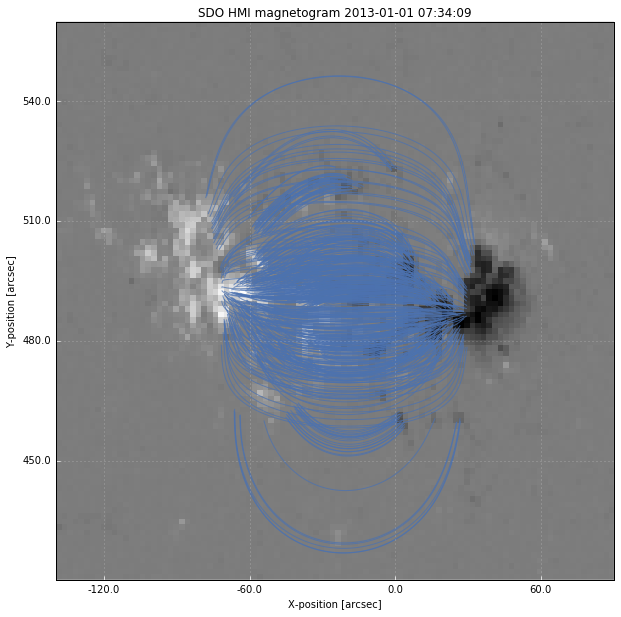

In [11]:
field.peek()